Inspired in: https://playground.tensorflow.org/

In [625]:
using Revise
using PyPlot, OCDNN, Printf, Random

In [626]:
function in_dir(f, path::String)
    current = pwd()
    cd(path)
    f()
    cd(current)
end

in_dir (generic function with 1 method)

In [671]:
Random.seed!(1234)
dataset = build_dataset(N_samples = 1000, N_noise = 50);
data, feat = dataset;

In [672]:
N,d = size(data);

In [673]:
idxs = feat .== 1;

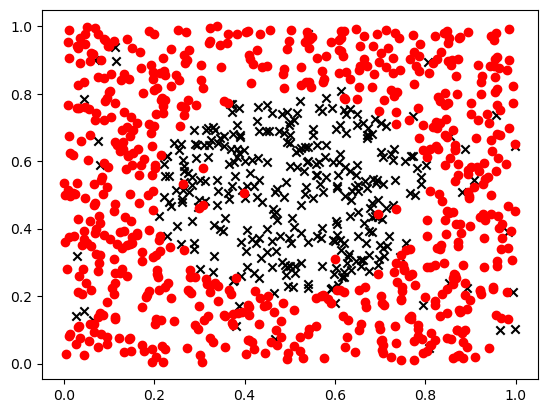

PyObject <matplotlib.collections.PathCollection object at 0x000000006E7B50C8>

In [674]:
scatter(data[:,1][idxs],data[:,2][idxs],marker="x", c = "k")
scatter(data[:,1][.!idxs],data[:,2][.!idxs],marker="o", c = "r")

In [699]:
nlayers = 6
channels = 2 # number of neurons per layer
niter = 10000
τ=0.1;
τ_max=10;
stepsize = 0.1;

In [700]:
A_eu = reshape([0],(1,1));
w_eu = [1];
A_ie = [0 0; 1 0];
w_ie = [0.5 ;0.5];
A_kutta4 = [0 0 0 0;0.5 0 0 0;0 0.5 0 0;0 0 1 0];
w_kutta4 = 1/6*[1;2;2;1];
A_kutta3 = [0 0 0;1/2 0 0;-1 2 0];
w_kutta3 = [1/6;2/3;1/6];

In [701]:
rk4 = OCDNN.ExplicitRungeKutta(A_kutta4,w_kutta4,"RK4");
rk3 = OCDNN.ExplicitRungeKutta(A_kutta3,w_kutta3,"RK3");
rk2 = OCDNN.ExplicitRungeKutta(A_ie,w_ie,"RK2");
euler = OCDNN.ExplicitRungeKutta(A_eu,w_eu,"Euler");
rks = [euler,rk2,rk3,rk4];

In [702]:
names = [rk.name for rk in rks];

In [703]:
eta = x -> exp(x)/(exp(x)+1)

#335 (generic function with 1 method)

In [704]:
problem = OCDNN.Problem(tanh, eta, feat);

In [705]:
function cb(iter, rkmethod, nlayers, α, log, Ctrls)
    period = 2000
    if rem(iter,period) == 0 || iter == 1
        @printf("\nMethod=%s, nlayers=%d, channels=%d\n",rkmethod.name,nlayers,Ctrls.channels)
        @printf("Iteration no: %d\n",iter)
        @printf("Value of alpha: %7.4f\n",α);
        @printf("Residual: %8.4f\n",log.loss[end])
        @printf("Norm Grad: %8.4e\n",log.grad_norm[end]);
        @printf("Accuracy: %8.4f %% \n",log.accuracy[end]*100);
        if iter > 1
            @printf("Time: %8.4f\n",sum(log.time[end-period+1:end]));
        end
    end
end

cb (generic function with 1 method)

In [706]:
all_results = [train_ode_dnn(dataset, nlayers, channels, rk, niter, τ, τ_max, stepsize, problem, cb) for rk in rks];


Method=Euler, nlayers=6, channels=2
Iteration no: 1
Value of alpha:  0.0250
Residual: 120.0892
Norm Grad: 9.1588e+01
Accuracy:  67.0000 % 

Method=Euler, nlayers=6, channels=2
Iteration no: 2000
Value of alpha:  0.0250
Residual:  37.3262
Norm Grad: 6.7707e-01
Accuracy:  91.9000 % 
Time:  15.2472

Method=Euler, nlayers=6, channels=2
Iteration no: 4000
Value of alpha:  0.0125
Residual:  30.4310
Norm Grad: 4.9418e-01
Accuracy:  93.5000 % 
Time:  12.6945

Method=Euler, nlayers=6, channels=2
Iteration no: 6000
Value of alpha:  0.0125
Residual:  28.5834
Norm Grad: 2.6986e-01
Accuracy:  94.1000 % 
Time:  13.4938

Method=Euler, nlayers=6, channels=2
Iteration no: 8000
Value of alpha:  0.0063
Residual:  27.5685
Norm Grad: 2.5996e-01
Accuracy:  94.3000 % 
Time:  13.4589

Method=Euler, nlayers=6, channels=2
Iteration no: 10000
Value of alpha:  0.0125
Residual:  26.8905
Norm Grad: 1.7656e-01
Accuracy:  94.4000 % 
Time:  13.6178

Method=RK2, nlayers=6, channels=2
Iteration no: 1
Value of alpha:  0

In [707]:
final_string = string(nlayers)*"_layers_"*string(N)*"_points_"*string(channels)*"_channels"
outputdir = "Classification\\"*final_string
if !isdir(outputdir)
    mkdir(outputdir)
end

"Classification\\6_layers_1000_points_2_channels"

In [708]:
all_Ctrls,all_logs = first.(all_results),last.(all_results);

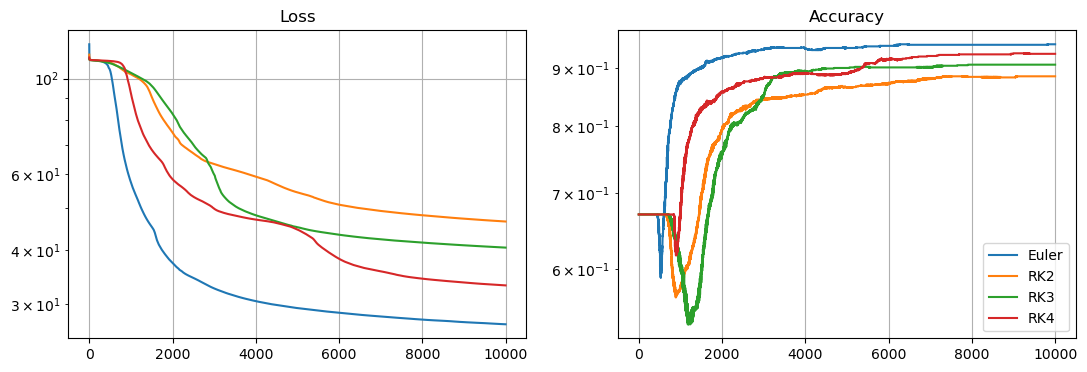

PyObject <matplotlib.legend.Legend object at 0x000000006E1F5888>

In [709]:
fig, axs = PyPlot.subplots(1,2,figsize=(13,4))
axs[1].set_title("Loss")
for i in 1:4
    axs[1].semilogy(all_logs[i].loss, label = names[i])
end
axs[1].grid()
axs[2].set_title("Accuracy")
for i in 1:4
    axs[2].semilogy(all_logs[i].accuracy, label = names[i])
end
axs[2].grid()
legend()

In [710]:
in_dir(outputdir) do
    fig.savefig("loss_acc_rks_"*final_string*".pdf")
end

In [711]:
all_times = [sum(all_logs[i].time) for i in 1:4];

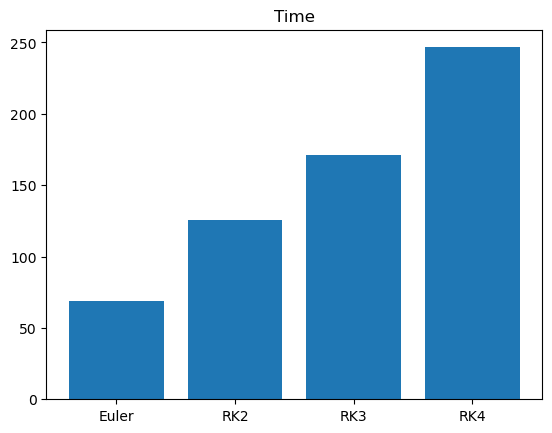

In [712]:
fig, ax = PyPlot.subplots()
ax.set_title("Time")
ax.bar(1:4,height=all_times)
ax.set_xticks(1:4)
ax.set_xticklabels(names);

In [713]:
in_dir(outputdir) do
    fig.savefig("time_rks_"*final_string*".pdf")
end

In [714]:
all_Ctrls_test = deepcopy.(all_Ctrls);

In [715]:
xs = collect(0:0.002:1)
ys = collect(0:0.002:1);

In [716]:
Y0_test = [[x,y] for x in xs, y in ys];

In [717]:
for i in 1:4
    all_Ctrls_test[i].Y0 = hcat(Y0_test...)';
end

In [718]:
classifiers = [[] for i in 1:4]
for i in 1:4
    classifiers[i] = OCDNN.RKforwardstepper(all_Ctrls_test[i],rks[i],problem).Classifier;
end

In [719]:
values = [reshape(round.(classifiers[i]), size(Y0_test))' for i in 1:4];

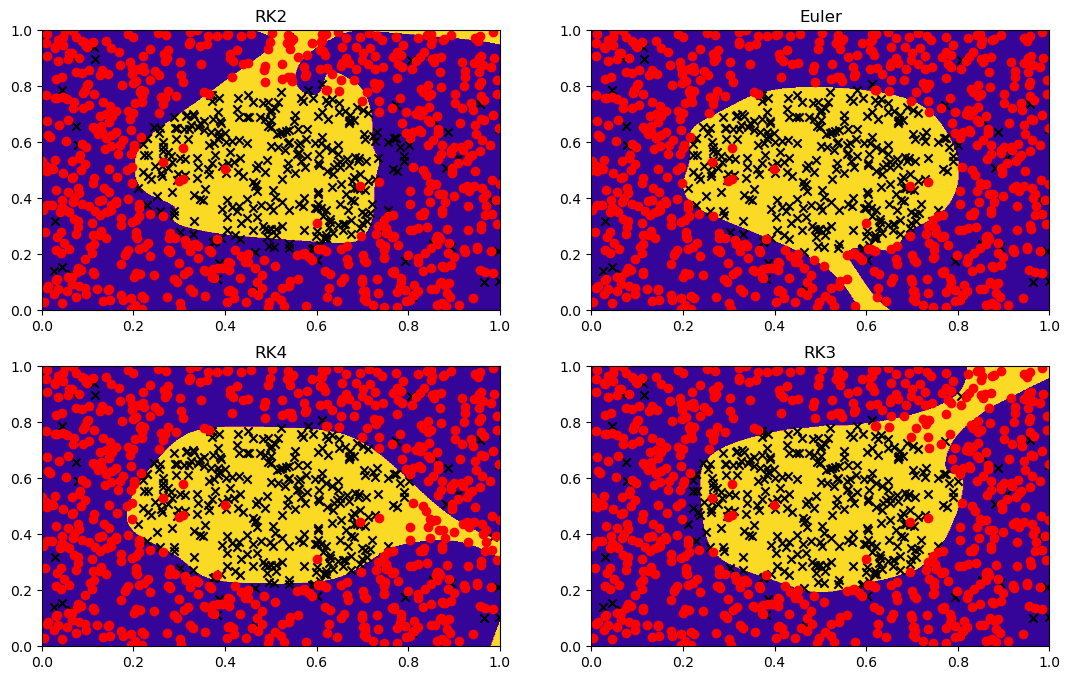

In [720]:
fig, axs = PyPlot.subplots(2,2,figsize=(13,8))
for i in 1:4
    m,n = Int64(floor((i+1)/2)),(i%2)+1
    axs[m,n].set_title(names[i])
    axs[m,n].contourf(xs,ys, values[i], cmap = "plasma")
    axs[m,n].scatter(data[:,1][idxs],data[:,2][idxs],marker="x", c = "k")
    axs[m,n].scatter(data[:,1][.!idxs],data[:,2][.!idxs],marker="o", c = "r")
end

In [721]:
in_dir(outputdir) do
    fig.savefig("contour_plots_rks_"*final_string*".pdf")
end